Nama : Olivia Ramadhani

Nim : 231011402280

Kelas : 05TPLE013

UAS KECERDASAN BUATAN


### Prediksi Nilai Ujian Siswa Menggunakan Decision Tree (Regresi)
### Tujuan: Memprediksi nilai ujian siswa (Exam_Score) berdasarkan faktor-faktor siswa yang tersedia pada dataset, seperti kebiasaan belajar, kehadiran, dukungan orang tua, akses sumber belajar, dan faktor lingkungan.


Variabel yang Digunakan
- Target (y): Exam_Score
- Fitur utama (X):
1. Hours_Studied
2. Attendance
3. Parental_Involvement
4. Access_to_Resources
5. Sleep_Hours
6. Motivation_Level
7. Tutoring_Sessions
8. Teacher_Quality
9. Distance_from_Home
10. Family_Income

Catatan: variabel Exam_Score tidak digunakan sebagai fitur agar tidak terjadi data leakage.








<b>Dataset dari kaggle</b>

Link : https://www.kaggle.com/datasets/lainguyn123/student-performance-factors


## 1> Library yang digunakan:

pandas/numpy 

ColumnTransformer + Pipeline 

DecisionTreeRegressor 

metrik: MAE, MSE, RMSE (+ R2 opsional)


In [1]:
import os
import zipfile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 2> Load Dataset + EDA

Fungsi load_student_data() akan mencoba:
- baca CSV langsung
- kalau tidak ada, ekstrak ZIP lalu cari CSV

df.head() menampilkan 5 baris awal.

In [28]:
import os
import zipfile
import pandas as pd

ZIP_PATH = "archive.zip"
CSV_PATH = "StudentPerformanceFactors.csv"
EXTRACT_DIR = "data_extracted"

def load_student_data(zip_path=ZIP_PATH, csv_path=CSV_PATH, extract_dir=EXTRACT_DIR):
    # Case 1: kalau ada CSV langsung
    if os.path.exists(csv_path):
        print(f" Loading from CSV: {csv_path}")
        return pd.read_csv(csv_path)
    
    # Case 2: kalau ada ZIP
    if os.path.exists(zip_path):
        print(f" ZIP found: {zip_path} → extracting to {extract_dir}/")
        os.makedirs(extract_dir, exist_ok=True)
        
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_dir)
        
        # cari file CSV di folder extract
        for root, dirs, files in os.walk(extract_dir):
            for f in files:
                if f.lower().endswith(".csv"):
                    found_csv = os.path.join(root, f)
                    print(f" Loading from extracted CSV: {found_csv}")
                    return pd.read_csv(found_csv)

    raise FileNotFoundError(
        
    )

df = load_student_data()
df.head()



 Loading from CSV: StudentPerformanceFactors.csv


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## 3 < EDA > (cek ukuran, tipe data, missing values)
- df.info() untuk lihat tipe kolom + null

- df.describe() ringkas statistik

- missing untuk cek kolom mana yang punya missing value

In [27]:
print("Shape (baris, kolom):", df.shape)
display(df.info())
display(df.describe(include="all").T.head(12))

# Missing value per kolom
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing


Shape (baris, kolom): (6607, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence 

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hours_Studied,6607.0,NaN,NaN,NaN,19.975329,5.990594,1.0,16.0,20.0,24.0,44.0
Attendance,6607.0,NaN,NaN,NaN,79.977448,11.547475,60.0,70.0,80.0,90.0,100.0
Parental_Involvement,6607,3,Medium,3362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Access_to_Resources,6607,3,Medium,3319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extracurricular_Activities,6607,2,Yes,3938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep_Hours,6607.0,NaN,NaN,NaN,7.02906,1.46812,4.0,6.0,7.0,8.0,10.0
Previous_Scores,6607.0,NaN,NaN,NaN,75.070531,14.399784,50.0,63.0,75.0,88.0,100.0
Motivation_Level,6607,3,Medium,3351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Internet_Access,6607,2,Yes,6108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tutoring_Sessions,6607.0,NaN,NaN,NaN,1.493719,1.23057,0.0,1.0,1.0,2.0,8.0


Parental_Education_Level    90
Teacher_Quality             78
Distance_from_Home          67
dtype: int64

## < 4 >Tentukan target (y) dan fitur (X)

y = Exam_Score

X = semua kolom selain target

In [29]:
TARGET = "Exam_Score"

if TARGET not in df.columns:
    raise ValueError(f"❌ Kolom target '{TARGET}' tidak ditemukan. Kolom yang ada: {list(df.columns)}")

X = df.drop(columns=[TARGET])
y = df[TARGET]

print(" Target:", TARGET)
print(" Jumlah fitur:", X.shape[1])





 Target: Exam_Score
 Jumlah fitur: 19


## <5> Preprocessing Data

1.Pisahkan fitur numerik dan kategorikal
- Numerik → imputasi median

- Kategorikal → imputasi modus + OneHotEncoding

2.Buat preprocessing pipeline
- SimpleImputer(median) aman untuk numerik

- SimpleImputer(most_frequent) + OneHotEncoder aman untuk kategori

- handle_unknown="ignore" mencegah error jika ada kategori baru di test set

In [23]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerik:", numeric_features)
print("Kategorikal:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


Numerik: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
Kategorikal: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


## <6> Split Training & Testing

0% train, 20% test

random_state=42 supaya hasil konsisten

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape, "| Test:", X_test.shape)


Train: (5285, 19) | Test: (1322, 19)


## <7> Build Model Decision Tree Regressor (Baseline)

Ini model awal (default) untuk pembanding

Metrik utama sesuai instruksi: MAE/MSE/RMSE

R² opsional (nilai tambah)


In [18]:
baseline_model = DecisionTreeRegressor(random_state=42)

baseline_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", baseline_model)
])

baseline_pipe.fit(X_train, y_train)

y_pred = baseline_pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== Baseline Decision Tree (Default) ===")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f} (opsional)")


=== Baseline Decision Tree (Default) ===
MAE  : 1.7421
MSE  : 12.5061
RMSE : 3.5364
R²   : 0.1152 (opsional)


## <8> Eksperimen Parameter (Tuning Sederhana)

Tujuan tuning: mengurangi overfitting dan meningkatkan performa.

max_depth, min_samples_leaf, min_samples_split adalah kunci kontrol kompleksitas pohon

GridSearchCV melakukan cross-validation 5-fold

scoring=neg_mean_absolute_error karena sklearn memakai “semakin besar semakin baik”; MAE dibalik jadi negatif

In [25]:
tree = DecisionTreeRegressor(random_state=42)

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", tree)
])

param_grid = {
    "model__max_depth": [3, 5, 8, 12, None],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__criterion": ["squared_error", "friedman_mse"]
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",  # fokus MAE
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print(" Best Params:", grid.best_params_)
print(" Best CV MAE:", -grid.best_score_)


Fitting 5 folds for each of 160 candidates, totalling 800 fits
 Best Params: {'model__criterion': 'squared_error', 'model__max_depth': None, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
 Best CV MAE: 1.6104441017990525


## <9> Evaluasi Model di Test Set


In [30]:
best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print("=== Best Decision Tree (After Tuning) ===")
print(f"MAE  : {mae_best:.4f}")
print(f"MSE  : {mse_best:.4f}")
print(f"RMSE : {rmse_best:.4f}")
print(f"R²   : {r2_best:.4f} (opsional)")


=== Best Decision Tree (After Tuning) ===
MAE  : 1.4851
MSE  : 6.2545
RMSE : 2.5009
R²   : 0.5575 (opsional)


## <10> Visualisasi Pohon Keputusan dengan Feature Names

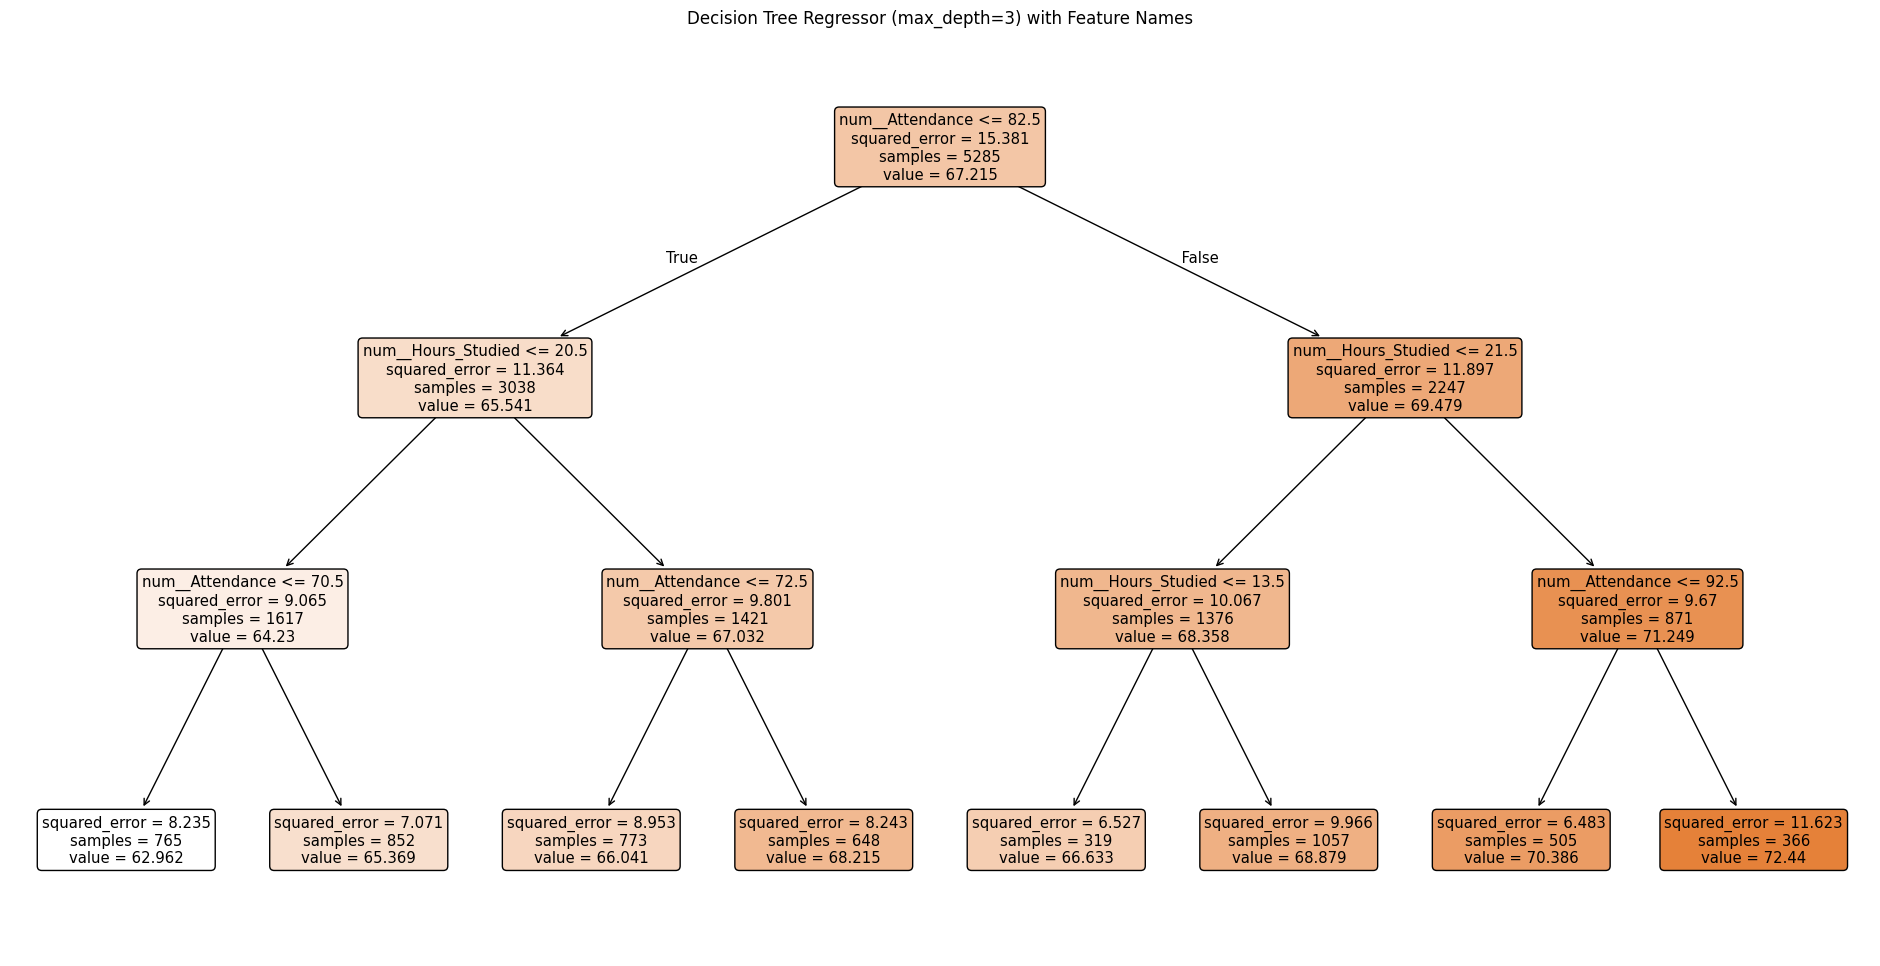

In [31]:
# Ambil feature names setelah preprocessing (sklearn versi baru umumnya bisa)
pre = viz_pipe.named_steps["preprocess"]

try:
    feature_names = pre.get_feature_names_out()
    plt.figure(figsize=(24, 12))
    plot_tree(
        viz_pipe.named_steps["model"],
        filled=True,
        rounded=True,
        feature_names=feature_names,
        max_depth=3
    )
    plt.title("Decision Tree Regressor (max_depth=3) with Feature Names")
    plt.show()
except Exception as e:
    print("Feature names tidak bisa ditampilkan otomatis (tergantung versi sklearn).")
    print("Error:", e)


## <11> Feature Importance (Top 15)

feature_importances_ menunjukkan fitur yang paling sering/berpengaruh dipakai split

,feature,importance
1,num__Attendance,0.481585
0,num__Hours_Studied,0.283033
3,num__Previous_Scores,0.060599
4,num__Tutoring_Sessions,0.029736
9,cat__Access_to_Resources_High,0.023639
6,cat__Parental_Involvement_High,0.022150
10,cat__Access_to_Resources_Low,0.009414
26,cat__School_Type_Public,0.008314
33,cat__Parental_Education_Level_High School,0.008142
24,cat__Teacher_Quality_Medium,0.008092


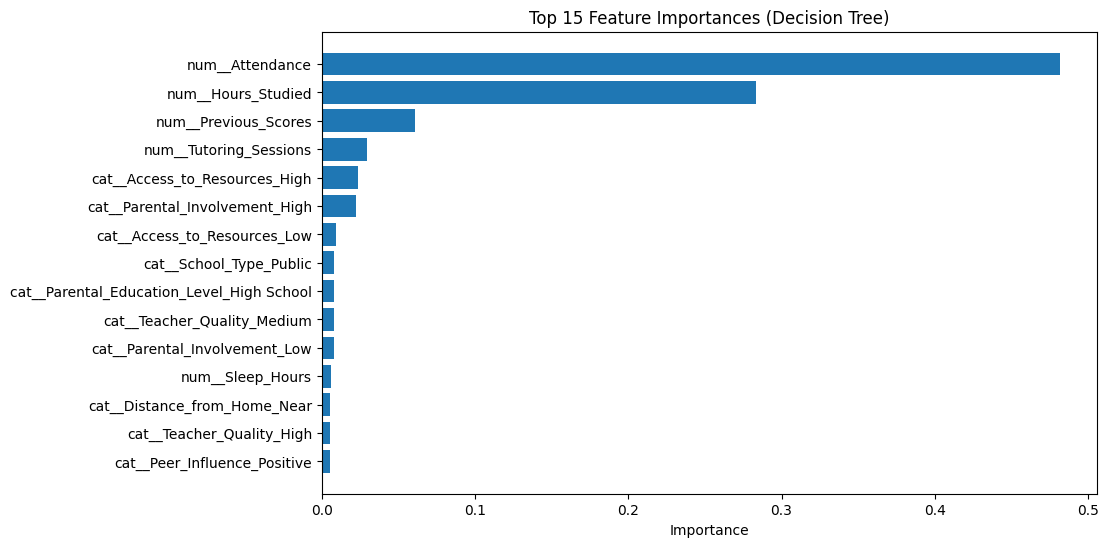

In [32]:
# Ambil nama fitur dari model terbaik (best_model)
best_pre = best_model.named_steps["preprocess"]
best_tree = best_model.named_steps["model"]

try:
    best_feature_names = best_pre.get_feature_names_out()
except Exception:
    best_feature_names = np.array([f"feature_{i}" for i in range(best_tree.feature_importances_.shape[0])])

importances = best_tree.feature_importances_
imp_df = pd.DataFrame({
    "feature": best_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

display(imp_df.head(15))

# Plot top 15
top15 = imp_df.head(15)[::-1]  # dibalik biar bar plot enak dibaca
plt.figure(figsize=(10, 6))
plt.barh(top15["feature"], top15["importance"])
plt.title("Top 15 Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.show()
